# Data Loading and Imports

In [10]:
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import Union, Sequence, Tuple

home = os.getcwd()
current = home
while 'models' not in os.listdir(current):
    current = Path(current).parent

sys.path.append(str(current))

In [11]:
DATA_FOLDER = os.path.join(Path(os.getcwd()).parent, 'data')
print(DATA_FOLDER)

/home/ayhem18/DEV/RecSys/data


initial thoughts about our users...
1. zip_code: convert to regions then aggregate
2. age: convert to age groups
3. Occupation: convert to smaller groups: For example, users with certain occupations might have more consistent ratings, with lower variance
4. There might be a correlation between the user's genders and the movie's gender 

In [12]:
movie_genre_index_map = {
0:"unknown",
1:"Action",
2:"Adventure",
3:"Animation",
4:"Children's",
5:"Comedy",
6:"Crime",
7:"Documentary",
8:"Drama",
9:"Fantasy",
10:"Film-Noir",
11:"Horror",
12: "Musical",
13:"Mystery",
14: "Romance",
15: "Sci-Fi",
16: "Thriller",
17: "War",
18: "Western"
}

In [13]:
# let's understand the movie data better
df_movie = pd.read_csv(os.path.join(DATA_FOLDER, 'ml-100k', 'u.item'), sep='|', encoding='latin', header=None)
df_movie.drop(columns=[1, 3, 4], inplace=True)
df_movie.head()
# add meaningful column names,
index_column_mapper = {0: 'id', 2: 'date'}
for k, v in movie_genre_index_map.items():
    index_column_mapper[k + 5] = v 

# we can see that our data is now ready to be processed further
df_movie.rename(columns=index_column_mapper, inplace=True)

In [14]:
df_movie.head()

,id,date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,01-Jan-1995,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,01-Jan-1995,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,01-Jan-1995,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,01-Jan-1995,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,01-Jan-1995,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


# The date Field

In [15]:
# most probably we will only need the year out of the movie release data
def prepare_date_column(df: pd.DataFrame) -> pd.DataFrame:
    if 'date' not in list(df.columns):
        raise ValueError(f"Please make sure that 'date' is one of the columns in the passed dataframe.\nFound: {len(df.columns)}")

    df_c = df.copy()
    # first convert the 'date' column from 
    df_c['date'] = pd.to_datetime(df_c['date'], format='mixed', dayfirst=True)
    # a single entry seem to have 'nan' for date. we can simply fill it with the previous year since the films 
    # seem to be grouped by dates in the dataframe
    df_c = df_c.ffill(axis=0)
    
    def extract_year(row) -> pd.Series:
        row['year'] = row['date'].year
        return row

    return df_c.apply(extract_year, axis='columns').drop(columns=['date'])

# let's take a look at the movie dataframe now
df_movie = prepare_date_column(df_movie)

In [16]:
df_movie.sort_values(by='year').head()

,id,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
674,675,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1922
1541,1542,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1926
616,617,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1930
655,656,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1931
1123,1124,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1932


A mere table does not tell as much about the movies.

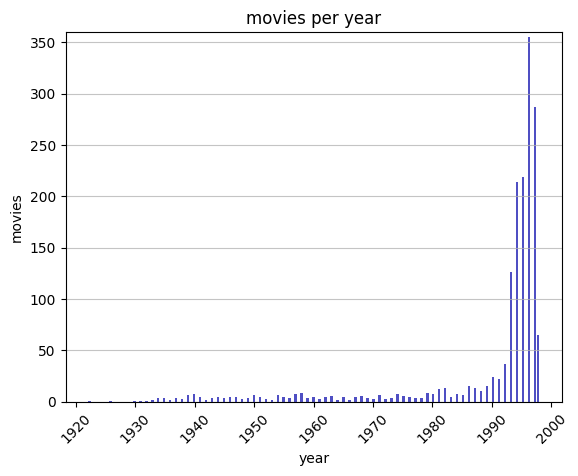

In [17]:
from visualization.visual import plot_histogram, bar_plot
plot_histogram(df_movie['year'], x_label='year', y_label='movies', title='movies per year')

We can see that the majority of the movies were released between the year 1990 and 2000.

# The movie Genre: Can we apply some feature-engineering techniques to improve the data ?

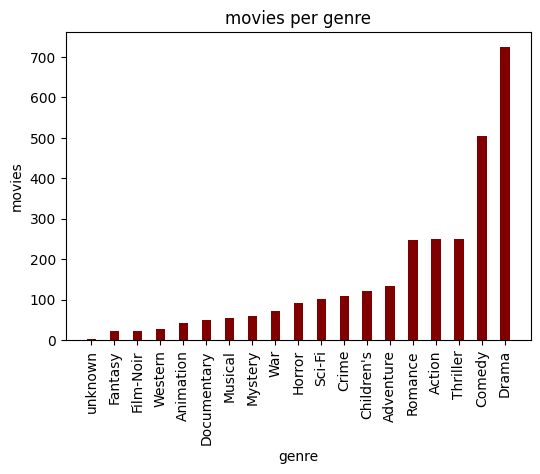

In [18]:
# to find the number of files per genre: extract only the 'genre' columns, then sum up on the row axis
movie_per_genre = df_movie.loc[:, [x for x in df_movie.columns if x not in ['year', 'id']]].sum(axis=0,numeric_only=True)

# let's display these values
# plot_histogram(movie_per_genre.values, x_label='genre', y_label='movies', title='movies per genre')
movie_pg_sorted = movie_per_genre.sort_values()
bar_plot(x=list(movie_pg_sorted.index), 
         y=movie_pg_sorted.values, 
         x_label='genre', 
         y_label='movies', 
         title='movies per genre',
         fig_size=(6, 4))


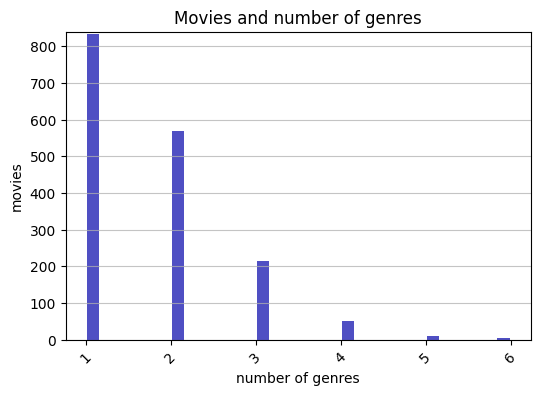

In [19]:
# is it possible to squeeze all these different genres into fewer genres
plt.figure(figsize=(6, 4))
genre_sum = df_movie.loc[:, [x for x in df_movie.columns if x not in ['year', 'id']]].sum(axis=1)
plot_histogram(x=genre_sum.values, x_label='number of genres', y_label='movies', title='Movies and number of genres')

Less than 5\% of the films have more than 4 genres at the same time.

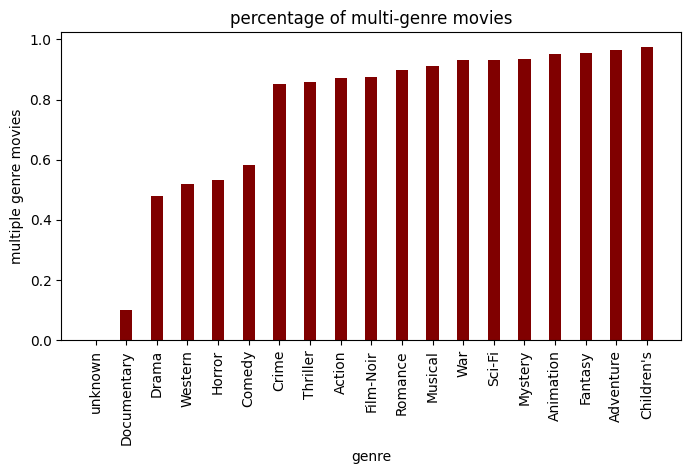

In [20]:
# let's try to 
from itertools import combinations
genre_data = df_movie.loc[:, [x for x in df_movie.columns if x not in ['year', 'id']]]
# let's try to understand which genres are more independent than others
# create a matrix cooccurence
genre_coindenpendence = np.zeros(shape=(19,), dtype=np.int32)
for row_id, row in genre_data.iterrows():
    non_zero_indices = [i for i, v in enumerate(row) if v != 0]
    if len(non_zero_indices) != 1:
        for i in non_zero_indices:
            genre_coindenpendence[i] += 1
# convert the numpy array to pd.Series, compute percentages and apply round
genre_coindenpendence = pd.Series(data=(genre_coindenpendence / movie_per_genre.values), index=movie_per_genre.index)
genre_coindenpendence = genre_coindenpendence.apply(lambda x: round(x, 3)).sort_values()
bar_plot(x=genre_coindenpendence.index, 
         y=genre_coindenpendence.values, 
         x_label='genre', 
         y_label='multiple genre movies',
         title='percentage of multi-genre movies', 
         fig_size=(8, 4))

In [21]:
# let's get the total number of genre combinations
from collections import Counter
genre_combinations = Counter()
for row_id, row in genre_data.iterrows():
    genre_combinations
    non_zero_indices = tuple([i for i, v in enumerate(row) if v != 0])
    genre_combinations[non_zero_indices] += 1

print(f"There are {len(genre_combinations)} combinations of genres")

There are 216 combinations of genres


/tmp/ipykernel_103624/4075465042.py:15: RuntimeWarning: invalid value encountered in divide
  genre_co_occurrence = genre_co_occurrence / np.sum(genre_co_occurrence, axis=1)


Text(0.5, 1.0, 'The genre coocurrence matrix')

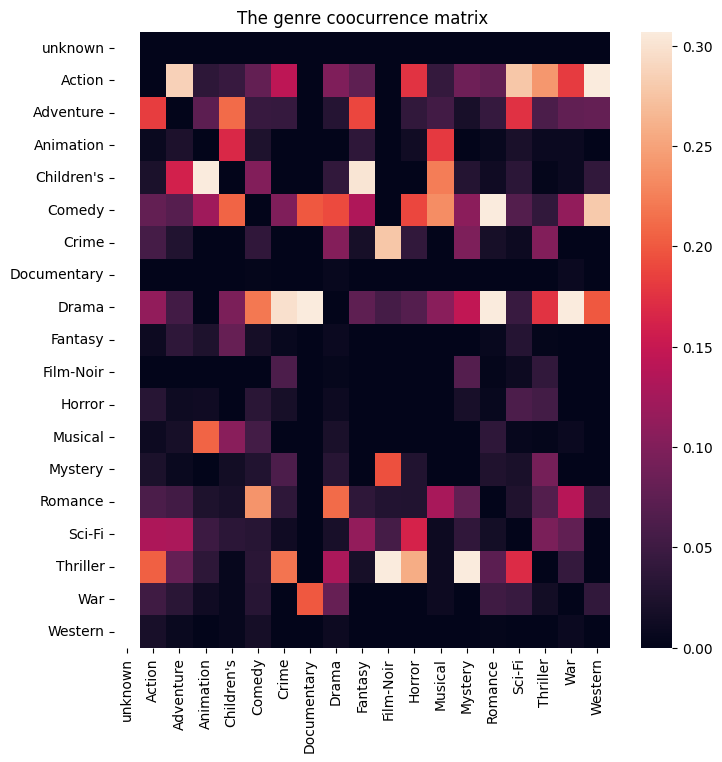

In [22]:
import seaborn as sns

# let's build a co-occurrence matrix and see if we can aggregate some genres
genre_co_occurrence = np.zeros(shape=(19, 19), dtype=np.int32)

for row_id, row in genre_data.iterrows():
    # extract non-zero indices 
    non_zero_indices = [i for i, v in enumerate(row) if v != 0]
    tuples = list(combinations(non_zero_indices, 2))    
    for i1, i2 in tuples:
        genre_co_occurrence[i1, i2] += 1
        genre_co_occurrence[i2, i1] += 1

# the absolute numbers might be misleading, let's divide by the total number of movies per genre
genre_co_occurrence = genre_co_occurrence / np.sum(genre_co_occurrence, axis=1)

plt.figure(figsize=(8, 8))
ax = sns.heatmap(genre_co_occurrence, 
            robust=True, 
            xticklabels=list(movie_per_genre.index),
            yticklabels=list(movie_per_genre.index)
            )
ax.set_title('The genre coocurrence matrix')

After this brief exploration of the movie data, I came to the following conclusions: 
1. out of the $2^{19}$ possible combinations, only $2^8$ combinations are present, suggesting that the current $19$ binary features are far from an optimized representation of the data
2. Reducing the genres into certain combination does not seem to be very straightforward as certain genres might appear in many combinations: for example the 'war' genre.

In [23]:
os.makedirs(os.path.join(DATA_FOLDER, 'prepared'), exist_ok=True)
df_movie.to_csv(os.path.join(DATA_FOLDER, 'prepared', "items.csv"), index=False)